# Summary

Grab data from AnnData object and use it to create a graph pkl

## Background

Data can be represented in a more complete way by utilizing edge features in graph attention networks and modifying the architecture based on empirical results from 2021 

## Objective

Use self-supervised learning to learn graphical representations of data and harness edge features in improving performance of predictive tasks

## Methods

GAT, edge features, self-supervised learning, representation learning, healthcare application, single-cell transcriptomic data

- use batch labels from dataset, train GAT to get edge coefficients from preds of those labels, use this for "batch effect correction" in the model, either by penalizing reliance on these edge features, or controlling for them in the final model 
- 

In [51]:
%matplotlib inline
%load_ext memory_profiler

import os
import time
import datetime
import sys
import pickle
import scanpy as sc
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

sc.settings.verbosity=2

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [6]:
import glob
dfp = '/home/ngr4/project/scnd/data'
glob.glob(os.path.join(dfp, '*h5ad'))

['/home/ngr4/project/scnd/data/mouse_210726.h5ad']

# Data

## check and modify

From Leon:
correct genotype

·   5wk WT= 7202, 72921, 72922

·   5wk SCA1= 7294, 72931, 72932

·   12wk wild-type: 22018, 2061, 2062

·   12wk SCA1: 22019, 2063, 2065

·   18wk WT: 6569, 65701, 65702

·   18wk SCA1: 6571, 65731, 65732

·   24wk wild-type: 1974, 2020, 20202

·   24wk SCA1: 1589, 2021, 20212

·   30wk WT: 5812, #5822, 58232

·   30wk SCA1: #58231, 58241, 58242


58231 and 5822 have been assigned WT and SCA1 originally, respectively

In [7]:
# load data
adata = sc.read('/home/ngr4/project/scnd/data/mouse_210726.h5ad')

#### originalm

In [78]:
# original
dt = adata.obs.loc[:, ['batch', 'genotype', 'timepoint']].drop_duplicates().sort_values(by=['timepoint', 'genotype'])
dt.groupby(['timepoint', 'genotype'])['batch'].apply(list)

timepoint  genotype
5wk        SCA1        [7294, 72931, 72932]
           WT          [7202, 72921, 72922]
12wk       SCA1         [22019, 2063, 2065]
           WT           [22018, 2061, 2062]
18wk       SCA1        [6571, 65731, 65732]
           WT          [6569, 65701, 65702]
24wk       SCA1         [1589, 2021, 20212]
           WT           [1974, 2020, 20202]
30wk       SCA1        [5822, 58241, 58242]
           WT          [5812, 58231, 58232]
Name: batch, dtype: object

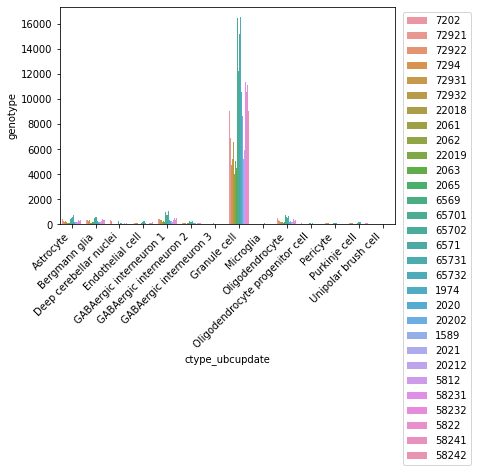

In [25]:
# count
barplot = sns.barplot(
    x='ctype_ubcupdate',
    y='genotype',
    hue='batch',
    data=adata.obs.groupby(['batch', 'ctype_ubcupdate']).count().reset_index(),
    )
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
barplot.legend(bbox_to_anchor=(1.01, 1))


In [64]:
dt = adata.obs.groupby(['batch', 'ctype_ubcupdate']).count().loc[:, 'genotype']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_210726_metadata_count.csv')

In [63]:
dt = 100*(adata.obs.groupby(['batch', 'ctype_ubcupdate']).count()/adata.obs.groupby('batch').count()).loc[:, 'genotype']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_210726_metadata.csv')

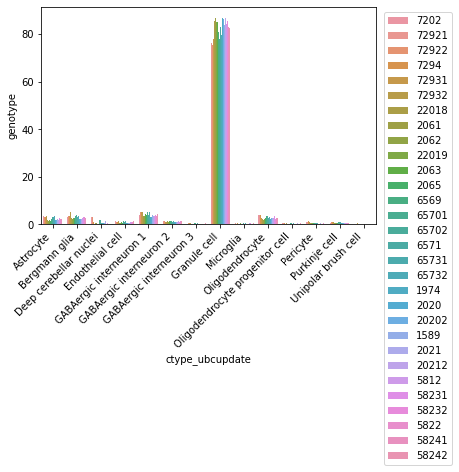

In [49]:
# percent
dt = 100*(adata.obs.groupby(['batch', 'ctype_ubcupdate']).count()/adata.obs.groupby('batch').count()).loc[:, 'genotype']
dt = dt.reset_index()
barplot = sns.barplot(
    x='ctype_ubcupdate',
    y='genotype',
    hue='batch',
    data=dt,
    )
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
barplot.legend(bbox_to_anchor=(1.01, 1))

#### modified

In [82]:
# 58231 is WT, should be SCA1
# 5822 is SCA1, should be WT
adata.obs['genotype_crct'] = adata.obs['genotype'].astype(str)
adata.obs.loc[adata.obs['batch']=='58231', 'genotype_crct'] = 'SCA1'
adata.obs.loc[adata.obs['batch']=='5822', 'genotype_crct'] = 'WT'

In [83]:
# original
dt = adata.obs.loc[:, ['batch', 'genotype_crct', 'timepoint']].drop_duplicates().sort_values(by=['timepoint', 'genotype_crct'])
dt.groupby(['timepoint', 'genotype_crct'])['batch'].apply(list)

timepoint  genotype_crct
5wk        SCA1              [7294, 72931, 72932]
           WT                [7202, 72921, 72922]
12wk       SCA1               [22019, 2063, 2065]
           WT                 [22018, 2061, 2062]
18wk       SCA1              [6571, 65731, 65732]
           WT                [6569, 65701, 65702]
24wk       SCA1               [1589, 2021, 20212]
           WT                 [1974, 2020, 20202]
30wk       SCA1             [58231, 58241, 58242]
           WT                 [5812, 58232, 5822]
Name: batch, dtype: object

In [ ]:
# quick viz with umap
dt = adata.obs.groupby(['batch', 'ctype_ubcupdate']).count().loc[:, 'genotype']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_210726_metadata_count.csv')

In [97]:
dt = 100*(adata.obs.groupby(['batch', 'ctype_ubcupdate']).count()/adata.obs.groupby('batch').count()).loc[:, 'genotype_crct']
dt = dt.reset_index()
pd.merge(dt, adata.obs.loc[:, ['batch' , 'genotype_crct', 'timepoint', 'ctype_ubcupdate']].drop_duplicates(), on=['batch' , 'ctype_ubcupdate']).to_csv('/home/ngr4/project/scnd/data/mouse_220805_metadata.csv')

In [84]:
# save
adata.write('/home/ngr4/project/scnd/data/mouse_220805.h5ad')

... storing 'genotype_crct' as categorical


In [98]:
sc.settings.figdir = '/home/ngr4/project/scnd/results/'

computing PCA
    with n_comps=50
    finished (0:02:37)


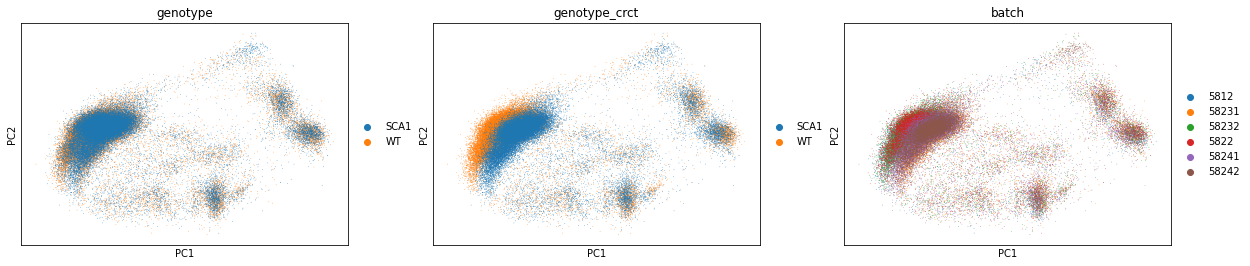

In [99]:
tdata = adata[adata.obs['timepoint']=='30wk'].copy()
sc.tl.pca(tdata)
sc.pl.pca_scatter(tdata, color=['genotype', 'genotype_crct', 'batch'], save='_batch_gtpye_crct.png')

#### Load AnnData obj

In [4]:
# fps
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'

def loader(fname,fpath,backed=None) : 
    start = time.time()
#     adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    adata = sc.read(filename=os.path.join(fpath,fname))
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    Anndata.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if False :
    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = loader(fname,pdfp)
    
if True :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    %memit adata = loader(fname,pdfp)

OSError: Unable to open file (truncated file: eof = 78117339136, sblock->base_addr = 0, stored_eof = 78137212556)

# Induction

Sample 1/3 of the data randomly, grab labels

In [14]:
# sample the data 
idx_train, idx_test = train_test_split(adata.obs.index, train_size=0.33)
%memit tdata = sc.AnnData(X=adata[adata.obs.index.isin(idx_train),:].X, obs=adata[adata.obs.index.isin(idx_train),:].obs)
temp = adata.obs.index[adata.obs.index.isin(idx_test)].to_list()
idx_val, idx_test = train_test_split(temp, train_size=0.1)
val = sc.AnnData(X=adata[adata.obs.index.isin(idx_val),:].X, obs=adata[adata.obs.index.isin(idx_val),:].obs)
temp = adata.obs.index[adata.obs.index.isin(idx_test)].to_list()
idx_test, _ = train_test_split(temp, train_size=0.11)
test = sc.AnnData(X=adata[adata.obs.index.isin(idx_test),:].X, obs=adata[adata.obs.index.isin(idx_test),:].obs)

def graph_pp(AnnData, bbknn=True):
    sc.tl.pca(AnnData, n_comps=50)
    if bbknn:
        sc.external.pp.bbknn(AnnData)
    else:
        sc.pp.neighbors(AnnData, n_pcs=100, n_neighbors=30)
    return AnnData

# make graph
tdata = graph_pp(tdata)
val = graph_pp(val)
test = graph_pp(test)

if False:
    del adata

peak memory: 83275.46 MiB, increment: 4650.95 MiB
computing PCA
    with n_comps=50
    finished (0:02:55)
computing batch balanced neighbors
	finished (0:02:27)
computing PCA
    with n_comps=50


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished (0:01:11)
computing batch balanced neighbors
	finished (0:00:25)
computing PCA
    with n_comps=50


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished (0:01:14)
computing batch balanced neighbors
	finished (0:00:25)


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


## Encoding 

Select tasks for prediction

1. yctype
2. ysca1
3. ygenotime (already done)
4. SCA1_5/12/18/24/30wk


In [16]:
# encode ctype 
ctype_encoder = {v:i for i,v in enumerate(tdata.obs['ctype'].unique())}
tdata.obs['yctype'] = tdata.obs['ctype'].map(ctype_encoder)
val.obs['yctype'] = val.obs['ctype'].map(ctype_encoder)
test.obs['yctype'] = test.obs['ctype'].map(ctype_encoder)

# encode WT/SCA1 blended across time
genotype_encoder = {'WT':0, 'SCA1':1}
tdata.obs['ysca1'] = tdata.obs['genotype'].map(genotype_encoder).astype(int)
val.obs['ysca1'] = val.obs['genotype'].map(genotype_encoder).astype(int)
test.obs['ysca1'] = test.obs['genotype'].map(genotype_encoder).astype(int)

# encode multi-label
tdata.obs['genotype_timepoint'] = tdata.obs['genotype'].astype(str) + tdata.obs['timepoint'].astype(str).apply(lambda x: '_{}'.format(x))
val.obs['genotype_timepoint'] = val.obs['genotype'].astype(str) + val.obs['timepoint'].astype(str).apply(lambda x: '_{}'.format(x))
test.obs['genotype_timepoint'] = test.obs['genotype'].astype(str) + test.obs['timepoint'].astype(str).apply(lambda x: '_{}'.format(x))

gt_encoder = {v:i for i,v in enumerate(tdata.obs['genotype_timepoint'].unique())}
tdata.obs['ygenotime'] = tdata.obs['genotype_timepoint'].map(gt_encoder)
val.obs['ygenotime'] = val.obs['genotype_timepoint'].map(gt_encoder)
test.obs['ygenotime'] = test.obs['genotype_timepoint'].map(gt_encoder)

# encode distinguishability of SCA1 at specific timepoints 
verbose = False
tdata.obs['SCA1_5wk'] = (tdata.obs['genotype_timepoint']=='SCA1_5wk').astype(int)
tdata.obs['SCA1_12wk'] = (tdata.obs['genotype_timepoint']=='SCA1_12wk').astype(int)
tdata.obs['SCA1_18wk'] = (tdata.obs['genotype_timepoint']=='SCA1_18wk').astype(int)
tdata.obs['SCA1_24wk'] = (tdata.obs['genotype_timepoint']=='SCA1_24wk').astype(int)
tdata.obs['SCA1_30wk'] = (tdata.obs['genotype_timepoint']=='SCA1_30wk').astype(int)
val.obs['SCA1_5wk'] = (val.obs['genotype_timepoint']=='SCA1_5wk').astype(int)
val.obs['SCA1_12wk'] = (val.obs['genotype_timepoint']=='SCA1_12wk').astype(int)
val.obs['SCA1_18wk'] = (val.obs['genotype_timepoint']=='SCA1_18wk').astype(int)
val.obs['SCA1_24wk'] = (val.obs['genotype_timepoint']=='SCA1_24wk').astype(int)
val.obs['SCA1_30wk'] = (val.obs['genotype_timepoint']=='SCA1_30wk').astype(int)
test.obs['SCA1_5wk'] = (test.obs['genotype_timepoint']=='SCA1_5wk').astype(int)
test.obs['SCA1_12wk'] = (test.obs['genotype_timepoint']=='SCA1_12wk').astype(int)
test.obs['SCA1_18wk'] = (test.obs['genotype_timepoint']=='SCA1_18wk').astype(int)
test.obs['SCA1_24wk'] = (test.obs['genotype_timepoint']=='SCA1_24wk').astype(int)
test.obs['SCA1_30wk'] = (test.obs['genotype_timepoint']=='SCA1_30wk').astype(int)

verbose = False
if verbose:
    # check encoding 
    print(tdata.obs['genotype_timepoint'].value_counts())
    for i in ['SCA1_5wk', 'SCA1_12wk','SCA1_18wk','SCA1_24wk','SCA1_30wk']:
        print(tdata.obs[i].sum())
        
    print(test.obs['genotype_timepoint'].value_counts())
    for i in ['SCA1_5wk', 'SCA1_12wk','SCA1_18wk','SCA1_24wk','SCA1_30wk']:
        print(test.obs[i].sum())



In [18]:
# create dictionary
def dictthat(AnnData, gene_ranger=True):
    """Prep dictionary for export.
    
    If gene_ranger, divide by zero can occur for 
    non-expressing genes. Thus, will floor those
    to 0.
    
    NOTE: customization re:y to predict is highly
    dependent on user input. ERGO, modify this 
    
    Arguments:
        AnnData (sc.AnnData): with graph stuff
        
    Returns:
        dict
    """
    if gene_ranger:
        # each gene in [0,1], divide by zeros to 0
        minimum = AnnData.X.min(axis=0)
        maximum = AnnData.X.max(axis=0)
        num = AnnData.X - minimum.todense()
        denom =  (maximum - minimum).todense()
        xhat = np.divide(num, denom, out=np.zeros_like(num), where=denom!=0) 
    else:
        # matrix in [0,1]
        xhat = (AnnData.X - AnnData.X.min()) / (AnnData.X.max() - AnnData.X.min())
        
    

    gdata = {'X':xhat,
             'adj':AnnData.uns['neighbors']['connectivities']+sparse.diags([1]*AnnData.shape[0], format='csr'),
             'feature_names':AnnData.var_names.to_list()}
    gdata['cell_id'] = AnnData.obs.index.to_list()
    for col in AnnData.obs.columns:
        gdata[col] = AnnData.obs[col].to_list()
    
    return gdata

gdata_train = dictthat(tdata)
gdata_val = dictthat(val)
gdata_test  = dictthat(test)



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.


In [19]:
# export
def pklthat(gdata, fname, fpath=pdfp): 
    with open(os.path.join(fpath,fname),'wb') as f :
        pickle.dump(gdata, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

pklthat(gdata_train, 'scnd_train_200528.pkl')
pklthat(gdata_val, 'scnd_val_200528.pkl')
pklthat(gdata_test, 'scnd_test_200528.pkl')

# clean
if True:
    del tdata, test, gdata_train, gdata_test

## modify pkl

Add batch encoding

In [50]:
def loadpkl(filename):
    with open (filename, 'rb') as f:
        temp = pickle.load(f)
        f.close()
    return temp

def add_batch(filename, date='200529'):
    gdata = loadpkl(filename)
    batch_encoder = {v:i for i,v in enumerate(np.unique(gdata['batch']))}
    gdata['ybatch'] = list(map(batch_encoder.get, gdata['batch']))
    pklthat(gdata, '{}_{}.pkl'.format(os.path.split(filename)[1].split('_20')[0], date))
    del gdata
    print('Batch added and pkl saved:\n  {}_{}.pkl'.format(os.path.split(filename)[1].split('_20')[0], date))

In [51]:
add_batch(os.path.join(pdfp,'scnd_train_200528.pkl'))
add_batch(os.path.join(pdfp,'scnd_val_200528.pkl'))
add_batch(os.path.join(pdfp,'scnd_test_200528.pkl'))

Batch added and pkl saved:
  scnd_train.pkl
Batch added and pkl saved:
  scnd_val.pkl
Batch added and pkl saved:
  scnd_test.pkl


In [53]:
# test
gdata = loadpkl(os.path.join(pdfp,'scnd_train_200529.pkl'))